# Question 3
### Daniyal Mehraeen - 402131102

### Part a)

In [176]:
import pandas as pd
import numpy as np
import os

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

from scipy.optimize import minimize


In [177]:
data = pd.read_csv("./P3.csv", index_col=0)

data.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,label
0,0.140023,0.265418,-0.535880,0.808262,-0.998551,1.147053,0.979441,0.722351,0.559936,0.399382,1.098400,0.036805,1.302542,-0.239813,0.625914,0.0
1,1.176099,1.690023,-0.737042,1.207350,-1.249740,-0.921881,0.065195,-0.581772,0.645254,-0.089174,-1.571598,0.633757,0.636572,1.233946,-0.300362,1.0
2,1.322751,0.635943,0.012525,0.027479,0.083267,0.447982,1.158902,1.177922,0.887521,0.018378,-0.395321,0.451929,0.744254,-0.492224,-0.316476,1.0
3,0.907289,-0.475599,-1.270970,1.837189,-2.471438,1.270536,-0.536260,-0.852590,0.778421,0.362119,-1.111151,0.153531,-0.342588,-0.147104,-0.585484,0.0
4,0.809604,1.039083,0.869025,-1.204626,1.756469,0.318814,-2.582921,-1.493409,-1.221354,0.435062,-0.068407,0.942154,0.329038,0.375319,-0.843292,1.0


In [178]:
data.shape

(300, 16)

In [179]:
data.isna().sum()

f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
f9       0
f10      0
f11      0
f12      0
f13      0
f14      0
f15      0
label    0
dtype: int64

In [180]:
features = data.iloc[:,:-1]
targets = data.iloc[:,-1]

scaler = MinMaxScaler()
features_normalized = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
features_normalized.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15
0,0.607913,0.536970,0.384854,0.612094,0.381920,0.732818,0.610219,0.636146,0.583061,0.488640,0.679177,0.513050,0.795799,0.462422,0.563402
1,0.755354,0.768625,0.331745,0.684951,0.347800,0.303775,0.468712,0.436799,0.595425,0.396893,0.293880,0.622990,0.677999,0.740225,0.404793
2,0.776223,0.597221,0.529639,0.469557,0.528865,0.587849,0.637996,0.705785,0.630534,0.417091,0.463624,0.589503,0.697046,0.414843,0.402034
3,0.717100,0.416473,0.190783,0.799932,0.181854,0.758425,0.375619,0.395402,0.614723,0.481642,0.360325,0.534547,0.504801,0.479898,0.355971
4,0.703199,0.662775,0.755764,0.244628,0.756140,0.561063,0.058837,0.297447,0.324923,0.495340,0.510800,0.679788,0.623601,0.578374,0.311826


In [181]:
data = pd.concat([features_normalized, targets], axis=1)
data.shape

(300, 16)

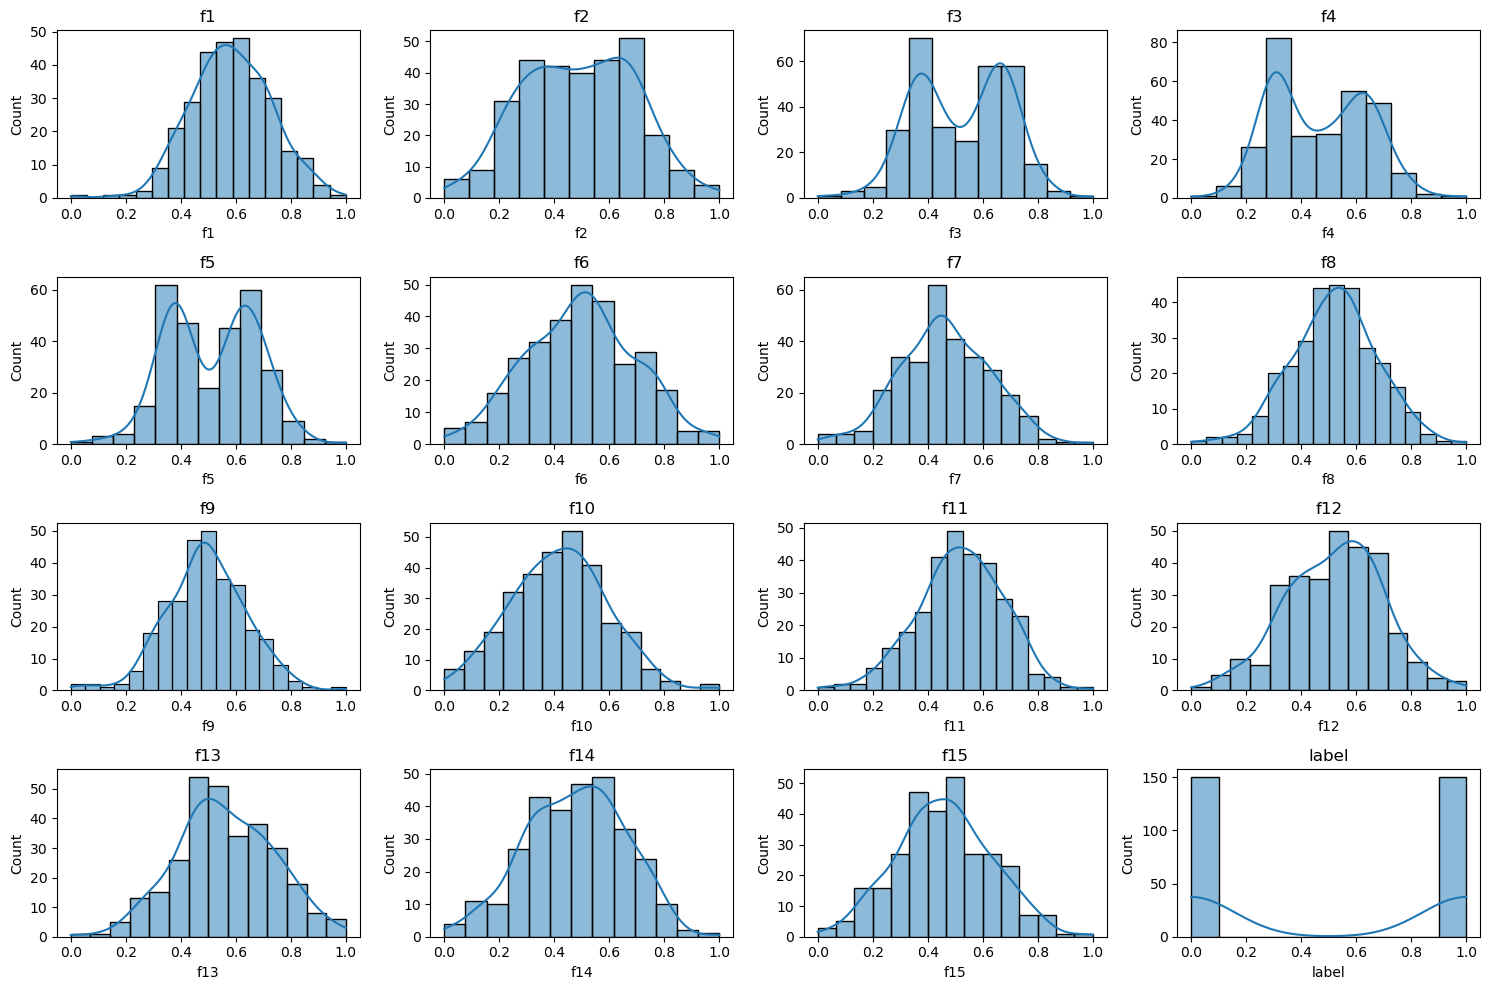

In [182]:
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(15, 10))
axs = axs.flatten()

for i, column in enumerate(data.columns):
    plt.subplot(4, 4, i+1)
    sns.histplot(data=data, x=column, kde=True)
    axs[i].set_title(column)

# Removing empty subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [183]:
# stratify=data[target_variable],
train_val_data, test_data = train_test_split(data, test_size=0.1, random_state=42)

### Part b)

#### Defining the necessary functions

In [184]:
def distance(X1,X2, weights):
    """
    Calculates and returns the weighted Euclidean distance between two points
    NOTE: this function eliminates the sqrt as it makes no difference in comparing two distances
    """
    return np.sum((weights)*(np.power(np.array(X1)-np.array(X2),2)),axis=0)

distance([1,1,1,1],[2,2,2,2],[2,1,1,1])

5

In [185]:
def accuracy_score(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    accuracy = correct_predictions / total_predictions
    return accuracy

In [186]:
def auc_score(y_true, y_pred):
    # Combining true labels and predicted probabilities into a single array
    predictions = np.column_stack((y_true, y_pred))

    # Sorting the predictions based on the predicted probabilities (descending order)
    sorted_predictions = predictions[predictions[:, 1].argsort()[::-1]]

    # Counting the number of positive instances in the true labels
    num_positives = np.sum(sorted_predictions[:, 0])

    # Initializing variables for the AUC calculation
    auc = 0.0
    prev_fpr = 0.0
    prev_tpr = 0.0

    # Iterating through the sorted predictions
    for i in range(len(sorted_predictions)):
        # Updating the true positive rate (tpr) and false positive rate (fpr)
        if sorted_predictions[i, 0] == 1:
            tpr = prev_tpr + 1 / num_positives
            fpr = prev_fpr
        else:
            tpr = prev_tpr
            fpr = prev_fpr + 1 / (len(sorted_predictions) - num_positives)

        # Updating the AUC using the trapezoidal rule
        auc += (tpr + prev_tpr) * (fpr - prev_fpr) / 2

        # Updating the previous values
        prev_tpr = tpr
        prev_fpr = fpr

    return auc

In [187]:
def log_loss(y_true, y_pred):
    epsilon = 1e-15  # small value to avoid log(0)

    # Cliping predicted probabilities to be within [epsilon, 1 - epsilon]
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # Calculating the log loss for each prediction
    log_losses = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    # Calculating the average log loss
    log_loss_score = np.mean(log_losses)

    return log_loss_score

In [188]:
def weighted_knn_loss(weights, data, K=2):
    # Printing the weights and K    
    print(f"K : {K}")
    print(f"weigths: {weights}")

    # Converting the K to integer
    k = int(K)
    
    # Extracting features and labels from the dataset
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Initializing the weigthed distances variable
    weighted_distances = np.zeros((X.shape[0], X.shape[0]))

    # Calculate pairwise distances between all observations
    for i in range(X.shape[0]):
        for j in range(i):
            weighted_distances[i][j] = distance(X.iloc[i,:],X.iloc[j,:],weights)
            weighted_distances[j][i] = weighted_distances[i][j]

    # Initializing an array to store the predictions for each observation
    y_predict = []
    
    # Iterateing over each observation
    for i in range(len(X)):
        # Calculating the weighted distances for the current observation / Deleting the Distance from itself
        weighted_distances_i = np.delete(weighted_distances[i],i)
        
        # Finding the indices of the k nearest neighbors
        nearest_indices = np.argsort(np.array(weighted_distances_i))[:k]
        
        # Predicting the label of the current observation based on the majority vote of the neighbors
        predicted_label = np.argmax(np.bincount(y.iloc[nearest_indices].astype(int)))

        # Appending the prediction for the current observation
        y_predict.append(predicted_label)

    # Calculating the performance metrics based on the predicted labels and true labels
    
    # accuracy = accuracy_score(y, y_predict)
    auc = auc_score(y, y_predict)
    # logloss = log_loss(y, y_predict)

    # Negative mean as we want to minimize
    return -auc


### Part c)

In [189]:
# Initializing the value of weights
initial_weights = np.zeros(train_val_data.shape[1] - 1)
initial_weights.shape

(15,)

In [190]:
# Initializing the value of k
initial_k = 6

In [191]:
def optimize_k_weights(params, data):
    k, weights = params[0], params[1:]
    loss = weighted_knn_loss(weights, data, k)
    print(f"Loss: {loss}")
    return loss

In [192]:
initial_params = np.concatenate([[initial_k], initial_weights])  # Initial values for k and weights
initial_params.shape

(16,)

In [193]:
# Creating the bounds for k
bounds = [
    (1,int(np.sqrt(train_val_data.shape[0]))),  # Bound for K
    (None, None),                               # Bound for weights
    (None, None),                               # Bound for weights
    (None, None),                               # Bound for weights
    (None, None),                               # Bound for weights
    (None, None),                               # Bound for weights
    (None, None),                               # Bound for weights
    (None, None),                               # Bound for weights
    (None, None),                               # Bound for weights
    (None, None),                               # Bound for weights
    (None, None),                               # Bound for weights
    (None, None),                               # Bound for weights
    (None, None),                               # Bound for weights
    (None, None),                               # Bound for weights
    (None, None),                               # Bound for weights
    (None, None),                               # Bound for weights
    ]



# Defining the optimization problem
optimization_result = minimize(
    optimize_k_weights,                         # Loss function to minimize
    x0=initial_params,                          # Initial values of weights and k
    args=(train_val_data, ),                    # Additional arguments for the loss function
    method='Nelder-Mead',                       # Optimization method
    bounds=bounds,                              # Bound for K to be in [1,n]
    options={"maxiter": 100, "disp": True}       # Max Iteration / displaying iterations info 
)

K : 6.0
weigths: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Loss: -0.5071883230904294
K : 6.300000000000001
weigths: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Loss: -0.5071883230904294
K : 6.0
weigths: [0.00025 0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.     ]
Loss: -0.5321005267778743
K : 6.0
weigths: [0.      0.00025 0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.     ]
Loss: -0.7377085162423176
K : 6.0
weigths: [0.      0.      0.00025 0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.     ]
Loss: -0.6145741878841078
K : 6.0
weigths: [0.      0.      0.      0.00025 0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.     ]
Loss: -0.5811018437225628
K : 6.0
weigths: [0.      0.      0.      0.      0.00025 0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.     ]
Loss: -0.5837906057945558
K

C:\Users\mehra\AppData\Local\Temp\ipykernel_15520\406933596.py:24: RuntimeWarning: Maximum number of iterations has been exceeded.
  optimization_result = minimize(


In [199]:
# Extract the optimized weights and k from the optimization result
optimized_weights = optimization_result.x[1:]
optimized_k = int(optimization_result.x[0])

print("Optimized Weights:", optimized_weights)
print("Optimized k:", optimized_k)

Optimized Weights: [-8.59434813e-06  3.12957445e-04  8.01112315e-05 -3.01496115e-06
  1.16766293e-04  3.02850464e-05  4.93092117e-06 -7.37415525e-05
  5.71853500e-05  1.08563647e-04 -8.44650776e-05 -5.32363163e-05
 -9.18676865e-05 -5.44882208e-05  2.92299767e-05]
Optimized k: 6


### Part d)

In [253]:
def knn_classifier(X_test, data, weights, k=2):
    
    # Extracting features and labels from the dataset
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Initializing an array to store the predictions for each observation
    y_predict = []

    # Iterate over each observation
    for i in range(X_test.shape[0]):
        weighted_distances_i = [distance(X_test.iloc[i,:],point,weights) for idx,point in X.iterrows()]

        # Finding the indices of the k nearest neighbors
        nearest_indices = np.argsort(np.array(weighted_distances_i))[:k]
        
        # Predicting the label of the current observation based on the majority vote of the neighbors
        predicted_label = np.argmax(np.bincount(y.iloc[nearest_indices].astype(int)))

        # Appending the prediction for the current observation
        y_predict.append(predicted_label)

    return y_predict


In [201]:
X_test, y_test = test_data.iloc[:,:-1], test_data.iloc[:,-1]

In [202]:
y_pred_best_weight = knn_classifier(X_test=X_test, data=train_val_data, weights=optimized_weights, k=optimized_k)
y_pred_vanilla = knn_classifier(X_test=X_test, data=train_val_data, weights=np.ones(data.shape[1]-1), k=optimized_k)

print("Weighted KNN:")
print(f"\tAUC Score: {accuracy_score(y_test,y_pred_best_weight)}")
print(f"\tAccuracy Score: {auc_score(y_test,y_pred_best_weight)}")
print(f"\tLog Loss : {log_loss(y_test,y_pred_best_weight)}")
print()
print("Vanilla KNN:")
print(f"\tAUC Score: {accuracy_score(y_test,y_pred_vanilla)}")
print(f"\tAccuracy Score: {auc_score(y_test,y_pred_vanilla)}")
print(f"\tLog Loss : {log_loss(y_test,y_pred_vanilla)}")
print()


Weighted KNN:
	AUC Score: 0.7666666666666667
	Accuracy Score: 0.7499999999999998
	Log Loss : 8.059127785222179

Vanilla KNN:
	AUC Score: 0.7666666666666667
	Accuracy Score: 0.776785714285714
	Log Loss : 8.05904782547916



### Part e)

In [203]:
n_features = data.shape[1]-1
features_to_remain = 5
n_subsets = 8

indices_subsets = []

for i in range(n_subsets):
    # Generating a random permutation of feature indices
    feature_indices = np.random.permutation(n_features)

    # Select the first (n_features - features_to_remove) indices
    selected_indices = feature_indices[:features_to_remain]

    # Appending selected indices into the subset
    indices_subsets.append(selected_indices)

print(np.array(indices_subsets))
    

[[ 9  0  1 14  3]
 [ 7  4  3  1 14]
 [14  2  4  9 11]
 [ 0  5  3  1 11]
 [ 6 14  5  8  3]
 [ 8  1 14 10  0]
 [ 1  8  4 12  2]
 [ 8 10  2 12 14]]


In [223]:
data_without_features = []

for i in range(n_subsets):
    data_without_features.append(pd.concat([data.iloc[:,indices_subsets[i]],data.iloc[:,-1]],axis=1))


In [235]:
accuracy_scores = []
auc_scores = []
log_losses = []

for i in range(n_subsets):
    # Spliting each data of the subset into test and train
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(data_without_features[i].iloc[:,:-1],data_without_features[i].iloc[:,-1], test_size=0.1, random_state=42)
    data_train_i = pd.concat([X_train_i,y_train_i], axis=1)

    # Selecting the optimized weights related to selected indices
    selected_weights = [optimized_weights[idx] for idx in indices_subsets[i]]

    # Predicting the value for test data
    y_pred_knn = knn_classifier(X_test=X_test_i, data=data_train_i, weights=selected_weights, k=optimized_k)

    # Appending the metric score to their list
    accuracy_scores.append(accuracy_score(y_test_i,y_pred_knn))
    auc_scores.append(auc_score(y_test_i,y_pred_knn))
    log_losses.append(log_loss(y_test_i,y_pred_knn))


In [236]:
# Printing the results
for i in range(n_subsets):
    print(f"Features: {[data.columns[idx] for idx in indices_subsets[i]]}")
    print()
    print(f"\tAUC Score: {auc_scores[i]}")
    print(f"\tAccuracy Score: {accuracy_scores[i]}")
    print(f"\tLog Loss : {log_losses[i]}")
    print()

Features: ['f10', 'f1', 'f2', 'f15', 'f4']

	AUC Score: 0.7767857142857141
	Accuracy Score: 0.8333333333333334
	Log Loss : 5.756489385732787

Features: ['f8', 'f5', 'f4', 'f2', 'f15']

	AUC Score: 0.7812499999999997
	Accuracy Score: 0.8
	Log Loss : 6.907808585477483

Features: ['f15', 'f3', 'f5', 'f10', 'f12']

	AUC Score: 0.5491071428571427
	Accuracy Score: 0.5
	Log Loss : 17.2696280766844

Features: ['f1', 'f6', 'f4', 'f2', 'f12']

	AUC Score: 0.8794642857142855
	Accuracy Score: 0.8666666666666667
	Log Loss : 4.605196839235764

Features: ['f7', 'f15', 'f6', 'f9', 'f4']

	AUC Score: 0.482142857142857
	Accuracy Score: 0.5
	Log Loss : 17.269494810446034

Features: ['f9', 'f2', 'f15', 'f11', 'f1']

	AUC Score: 0.8258928571428569
	Accuracy Score: 0.8666666666666667
	Log Loss : 4.605223492483437

Features: ['f2', 'f9', 'f5', 'f13', 'f3']

	AUC Score: 0.7991071428571427
	Accuracy Score: 0.8
	Log Loss : 6.907755278982137

Features: ['f9', 'f11', 'f3', 'f13', 'f15']

	AUC Score: 0.43749999999

In [257]:
best_acc_idx = np.argmax(np.array(accuracy_scores))
best_auc_idx = np.argmax(np.array(auc_scores))
best_log_idx = np.argmin(np.array(log_losses))

In [258]:
print(f"Best Accuracy Score (Random): {accuracy_scores[best_acc_idx]} for features: {[data.columns[idx] for idx in indices_subsets[best_acc_idx]]}")
print(f"Best AUC Score (Random): {auc_scores[best_auc_idx]} for features: {[data.columns[idx] for idx in indices_subsets[best_auc_idx]]}")
print(f"Lowest Log Loss (Random): {log_losses[best_log_idx]} for features: {[data.columns[idx] for idx in indices_subsets[best_log_idx]]}")

Best Accuracy Score (Random): 0.8666666666666667 for features: ['f1', 'f6', 'f4', 'f2', 'f12']
Best AUC Score (Random): 0.8794642857142855 for features: ['f1', 'f6', 'f4', 'f2', 'f12']
Lowest Log Loss (Random): 4.605196839235764 for features: ['f1', 'f6', 'f4', 'f2', 'f12']


### Part f)

In [254]:
# Selecting top 5 indices having highest weights
selected_indices = np.argsort(optimized_weights)[-features_to_remain:]

# Spliting data into test and train set
data_weighted = pd.concat([data.iloc[:,selected_indices], data.iloc[:,-1]], axis=1)
X_train_weighted, X_test_weighted, y_train_weighted, y_test_weighted = train_test_split(data_weighted.iloc[:,:-1], data_weighted.iloc[:,-1], test_size=0.1, random_state=42)
data_train_weighted = pd.concat([X_train_weighted,y_train_weighted], axis=1)

# Selecting the optimized weights related to selected indices
selected_weights = [optimized_weights[idx] for idx in selected_indices]

# Predicting the value for test data
y_pred_weighted = knn_classifier(X_test=X_test_weighted, data=data_train_weighted, weights=selected_weights, k=optimized_k)

# Printing the Results
print(f"Accuracy: {accuracy_score(y_test_weighted,y_pred_weighted)}")
print(f"AUC: {auc_score(y_test_weighted,y_pred_weighted)}")
print(f"Log Loss: {log_loss(y_test_weighted,y_pred_weighted)}")



Accuracy: 0.8
AUC: 0.8303571428571427
Log Loss: 6.90778193222981
